In [1]:
import os,csv,re
import pandas as pd
import numpy as np
import scanpy as sc
import math
import SpaGCN as spg
from scipy.sparse import issparse
import random, torch
import warnings
warnings.filterwarnings("ignore")
import matplotlib.colors as clr
import matplotlib.pyplot as plt
import SpaGCN as spg
from pathlib import Path
from sklearn import metrics
#In order to read in image data, we need to install some package. Here we recommend package "opencv"
#inatll opencv in python
#!pip3 install opencv-python
# import cv2

/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/anndata/utils.py:429: 

In [2]:
spg.__version__

'1.2.7'

In [3]:
data_root = Path('../data/DLPFC')

# sample name
sample_name = '151674'
n_clusters = 5 if sample_name in ['151669', '151670', '151671', '151672'] else 7
adata = sc.read_visium(data_root / sample_name)
print(adata)
adata.var_names_make_unique()

df_meta = pd.read_csv(data_root / sample_name / 'metadata.tsv', sep='\t')
adata.obs['layer_guess'] = df_meta['layer_guess']

AnnData object with n_obs × n_vars = 3673 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'


In [4]:
x_pixel = adata.obsm['spatial'][:,0]
y_pixel = adata.obsm['spatial'][:,1]
adj = spg.calculate_adj_matrix(x=x_pixel,y=y_pixel, histology=False)

Calculateing adj matrix using xy only...


In [5]:
adata.var_names_make_unique()
spg.prefilter_genes(adata,min_cells=3) # avoiding all genes are zeros
spg.prefilter_specialgenes(adata)
#Normalize and take log for UMI
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

In [6]:
p=0.5 
#Find the l value given p
l=spg.search_l(p, adj, start=0.01, end=1000, tol=0.01, max_run=100)

Run 1: l [0.01, 1000], p [0.0, 303.86047687500917]
Run 2: l [0.01, 500.005], p [0.0, 83.68516540527344]
Run 3: l [0.01, 250.0075], p [0.0, 21.29427146911621]
Run 4: l [0.01, 125.00874999999999], p [0.0, 4.7398552894592285]
Run 5: l [0.01, 62.509375], p [0.0, 0.5102378129959106]
Run 6: l [31.2596875, 62.509375], p [0.0003401041030883789, 0.5102378129959106]
Run 7: l [46.884531249999995, 62.509375], p [0.07612454891204834, 0.5102378129959106]
Run 8: l [54.69695312499999, 62.509375], p [0.2405151128768921, 0.5102378129959106]
Run 9: l [58.6031640625, 62.509375], p [0.36328089237213135, 0.5102378129959106]
Run 10: l [60.556269531249995, 62.509375], p [0.433931827545166, 0.5102378129959106]
Run 11: l [61.532822265625, 62.509375], p [0.47140347957611084, 0.5102378129959106]
recommended l =  62.021098632812496


In [7]:
n_clusters=7
#Set seed
r_seed=t_seed=n_seed=100
#Seaech for suitable resolution
res=spg.search_res(adata, adj, l, n_clusters, start=0.7, step=0.1, tol=5e-3, lr=0.05, max_epochs=20, r_seed=r_seed, t_seed=t_seed, n_seed=n_seed)

Start at res =  0.7 step =  0.1
Initializing cluster centers with louvain, resolution =  0.7
Epoch  0
Epoch  10
Res =  0.7 Num of clusters =  8
Initializing cluster centers with louvain, resolution =  0.6
Epoch  0
Epoch  10
Res =  0.6 Num of clusters =  7
recommended res =  0.6


In [8]:
clf=spg.SpaGCN()
clf.set_l(l)
#Set seed
random.seed(r_seed)
torch.manual_seed(t_seed)
np.random.seed(n_seed)
#Run
clf.train(adata,adj,init_spa=True,init="louvain",res=res, tol=5e-3, lr=0.05, max_epochs=200)
y_pred, prob=clf.predict()
adata.obsm['feature'] = prob
adata.obs["pred"]= y_pred
adata.obs["pred"]=adata.obs["pred"].astype('category')

Initializing cluster centers with louvain, resolution =  0.6
Epoch  0
Epoch  10
Epoch  20
Epoch  30
delta_label  0.0038115981486523277 < tol  0.005
Reach tolerance threshold. Stopping training.
Total epoch: 31


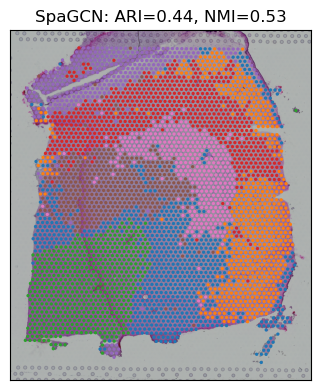

In [9]:
sub_adata = adata[~pd.isnull(adata.obs['layer_guess'])]
ARI = metrics.adjusted_rand_score(sub_adata.obs['layer_guess'], sub_adata.obs['pred'])
NMI = metrics.normalized_mutual_info_score(sub_adata.obs['layer_guess'], sub_adata.obs['pred'])
fig, axes = plt.subplots(1,1,figsize=(4, 4))
sc.pl.spatial(adata, color='pred', ax=axes, show=False,legend_loc=None)
axes.set_title('SpaGCN: ARI=%.2f, NMI=%.2f' % (ARI, NMI))
axes.set_xlabel('')
axes.set_ylabel('')
plt.tight_layout()
output_dir = ('./spagcn_ARI_NMI')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
output_path = os.path.join(output_dir, f"spagacn_{sample_name}_ARI.svg")
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()

In [10]:
output_dir1 = ('./feature')
if not os.path.exists(output_dir1):
    os.makedirs(output_dir1)
output_path = os.path.join(output_dir1, f"{sample_name}.h5ad")
adata.write_h5ad(output_path)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


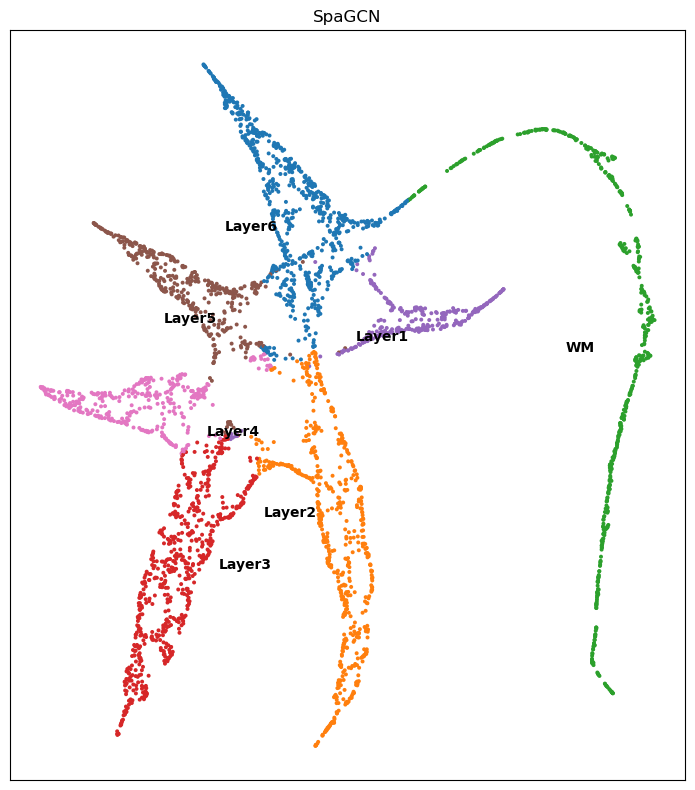

In [13]:
sc.pp.neighbors(adata, use_rep='feature', metric='cosine')
sc.tl.umap(adata, min_dist=0.2, spread=0.6)

fig, axes = plt.subplots(1, 1, figsize=(8 , 8))
sc.pl.umap(adata, color='pred', ax=axes, show=False,legend_loc=None)
axes.set_title('SpaGCN')
axes.set_aspect(1)

for cluster in adata.obs['layer_guess'].unique():
    # 计算每个类别的 UMAP 中心点
    cluster_points = adata[adata.obs['layer_guess'] == cluster].obsm['X_umap']
    x_mean, y_mean = cluster_points[:, 0].mean(), cluster_points[:, 1].mean()

    # 在中心点处添加标签
    axes.text(
        x=x_mean,  # X 坐标
        y=y_mean,  # Y 坐标
        s=cluster,  # 标签内容
        fontsize=10,
        ha='center',  # 水平对齐
        va='center',  # 垂直对齐
        color='black',  # 标签颜色
        fontweight='bold'  # 标签字体加粗
    )

axes.set_xlabel('')
axes.set_ylabel('')
plt.tight_layout()
output_path = os.path.join('./clustering_results', f"spagacn_{sample_name}.svg")
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()